# Naive Bayes - Ejemplo de Clasificación

Por [Eduardo Graells-Garrido](https://twitter.com/carnby)

En este ejemplo veremos una aplicación concreta de Naive Bayes para clasificar texto.

Utilizaremos datos de DBpedia, que es una versión estructurada de Wikipedia, y datos que se utilizaron en este artículo científico:

  - Wagner, C., Graells-Garrido, E., Garcia, D., & Menczer, F. (2016). [Women through the glass ceiling: gender asymmetries in Wikipedia](https://link.springer.com/article/10.1140/epjds/s13688-016-0066-4). EPJ Data Science, 5(1), 5.

Ese dataset contiene biografías de persona y una etiqueta de sexo binaria (hombre/mujer). Lo que haremos es entrenar un clasificador para decidir si una biografía de la cual no conocemos el sexo pertenece a un hombre o a una mujer.

## Datos

In [ ]:
#!wget http://downloads.dbpedia.org/2016-10/core-i18n/es/long_abstracts_es.tql.bz2

In [2]:
!bunzip2 -c long_abstracts_es.tql.bz2 | head -n 3

# started 2017-02-11T14:51:42Z
<http://es.dbpedia.org/resource/Astronomía_galáctica> <http://dbpedia.org/ontology/abstract> "Se denomina astronomía galáctica a la investigación astronómica de nuestra galaxia, la Vía Láctea. La diferencia entre astronomía galáctica y astronomía extragaláctica sólo se empezó a hacer a principios del siglo pasado, cuando las observaciones de Edwin Hubble mostraron sin lugar a dudas que la nebulosa de Andrómeda era una galaxia similar a la nuestra, y a una considerable distancia de ella. Los objetos de interés en nuestra galaxia son muchos, incluyendo estrellas, nubes interestelares —-que es donde la formación estelar se realiza—-, nuestro centro galáctico —-que estamos casi seguros posee un agujero negro—-, etc."@es <http://es.wikipedia.org/wiki/Astronomía_galáctica?oldid=90334279> .
<http://es.dbpedia.org/resource/Comunicaciones_de_Andorra> <http://dbpedia.org/ontology/abstract> "Correo: Es gratuito dentro del país y está atendido por Correos de España y

Utilizaremos Pandas para cargar la meta-data de las biografías:

In [1]:
import pandas as pd

In [2]:
person_data = pd.read_csv('person_data_es.csv.gz', index_col='uri')
person_data.sample(5)

,wikidata_entity,class,gender,edition_count,available_english,available_editions,birth_year,death_year,birth_place,death_place,same_as,label
uri,,,,,,,,,,,,
http://es.dbpedia.org/resource/Rabih_Abou-Khalil,Q449571,http://dbpedia.org/ontology/Artist,male,16,True,es|no|ru|it|lt|pt|fi|hu|he|de|nl|fr|ja|ar|tr|en,NaN,NaN,NaN,NaN,http://dbpedia.org/resource/Rabih_Abou-Khalil,Rabih Abou-Khalil
http://es.dbpedia.org/resource/Philipp_Boy,Q61437,http://dbpedia.org/ontology/Athlete,male,16,True,es|uk|zh|eo|fa|no|ru|it|ko|pt|fi|nl|de|fr|ja|en,NaN,NaN,NaN,NaN,http://dbpedia.org/resource/Philipp_Boy,Philipp Boy
http://es.dbpedia.org/resource/Paul_Kummer,Q64009,http://dbpedia.org/ontology/Scientist,male,9,True,es|ru|it|pt|fi|ca|de|fr|en,NaN,NaN,NaN,NaN,http://dbpedia.org/resource/Paul_Kummer,Paul Kummer
http://es.dbpedia.org/resource/Urien,Q6157422,http://dbpedia.org/ontology/FictionalCharacter,male,1,False,es,NaN,NaN,NaN,NaN,http://wikidata.org/entity/Q6157422,Urien
http://es.dbpedia.org/resource/Sigmundur_Davíð_Gunnlaugsson,Q463588,http://dbpedia.org/ontology/Politician,male,27,True,es|zh|be|is|pt|oc|lb|ja|no|cs|la|fi|sv|fr|uk|s...,NaN,NaN,NaN,NaN,http://dbpedia.org/resource/Sigmundur_Davíð_Gu...,Sigmundur Davíð Gunnlaugsson


In [3]:
person_uris = set(person_data.index)
len(person_uris)

170864

El archivo con la introducción (autocontenida) de cada artículo de Wikipedia lo descargamos más arriba. Lo leeremos línea por línea (nos limitaremos a leer las primeras 500 mil líneas del archivo, por simplicidad), extraeremos el texto utilizando una expresión regular, y nos quedaremos con las que sean biografías de personas, que cruzaremos con los metadatos disponibles.

In [4]:
import bz2
import re

parts = re.compile('<(.+)> <(.+)> "(.*)"@es.*')

In [5]:
from itertools import islice

records = []

with bz2.open('long_abstracts_es.tql.bz2') as f:
    for line in islice(f, 500000):
        line = line.decode('utf-8')
        match = parts.match(line)
        if match:
            groups = match.groups()
            if groups[0] in person_uris:
                records.append({
                    'person_uri': groups[0],
                    'category': groups[1],
                    'text': groups[2]
                })
            
records = pd.DataFrame.from_records(records).set_index('person_uri').join(person_data, how='left')
print(len(records))
records.head()

73471


,category,text,wikidata_entity,class,gender,edition_count,available_english,available_editions,birth_year,death_year,birth_place,death_place,same_as,label
person_uri,,,,,,,,,,,,,,
http://es.dbpedia.org/resource/Asaph_Hall,http://dbpedia.org/ontology/abstract,"Asaph Hall (Goshen, Connecticut, EE. UU.,15 de...",Q106559,http://dbpedia.org/ontology/Scientist,male,40,True,es|zh|eo|be|ko|pt|lb|ja|ka|no|cs|ro|fi|sv|he|d...,NaN,NaN,http://es.dbpedia.org/resource/Estados_Unidos,http://es.dbpedia.org/resource/Estados_Unidos,http://dbpedia.org/resource/Asaph_Hall,Asaph Hall
http://es.dbpedia.org/resource/Ana_María_Matute,http://dbpedia.org/ontology/abstract,"Ana María Matute Ausejo (Barcelona, España, 26...",Q235403,http://dbpedia.org/ontology/Writer,female,21,True,es|simple|eo|fa|sr|ru|it|ast|oc|ro|sv|ca|de|an...,NaN,NaN,http://es.dbpedia.org/resource/España,http://es.dbpedia.org/resource/España,http://dbpedia.org/resource/Ana_María_Matute,Ana María Matute
http://es.dbpedia.org/resource/Antonio_Vivaldi,http://dbpedia.org/ontology/abstract,"Antonio Lucio Vivaldi, (Venecia, 4 de marzo de...",Q1340,http://dbpedia.org/ontology/Artist,male,95,True,es|io|qu|oc|la|he|an|ga|war|af|id|tt|yi|ms|et|...,NaN,NaN,NaN,NaN,http://dbpedia.org/resource/Antonio_Vivaldi,Antonio Vivaldi
http://es.dbpedia.org/resource/Albert_Einstein,http://dbpedia.org/ontology/abstract,Albert Einstein (en alemán [ˈalbɛɐ̯t ˈaɪnʃtaɪn...,Q937,http://dbpedia.org/ontology/Scientist,male,117,True,es|io|wa|qu|oc|ne|am|la|he|an|ga|af|war|id|tt|...,NaN,NaN,NaN,http://es.dbpedia.org/resource/Estados_Unidos,http://dbpedia.org/resource/Albert_Einstein,Albert Einstein
http://es.dbpedia.org/resource/Anthony_Quinn,http://dbpedia.org/ontology/abstract,Anthony Quinn (Antonio Rodolfo Quinn Oaxaca: C...,Q83484,http://dbpedia.org/ontology/Artist,male,65,True,es|zh|eo|be|io|ko|pt|oc|lb|nn|ml|ja|ar|th|lv|a...,NaN,NaN,http://es.dbpedia.org/resource/México,http://es.dbpedia.org/resource/Estados_Unidos,http://dbpedia.org/resource/Anthony_Quinn,Anthony Quinn


Veamos como se distribuye la variable `gender` en el dataset:

In [6]:
records.gender.value_counts()

male                  61296
female                12170
transgender female        4
transgender male          1
Name: gender, dtype: int64

Aparte de un desbalance en la cantidad de biografías, vemos que también hay personas trans. Como son tan pocas, les quitaremos el prefijo _transgender_:

In [7]:
records.gender.replace('transgender female', 'female', inplace=True)
records.gender.replace('transgender male', 'male', inplace=True)

In [8]:
records.gender.value_counts()

male      61297
female    12174
Name: gender, dtype: int64

Así se ve una biografía de ejemplo:

In [9]:
print(records.loc['http://es.dbpedia.org/resource/Albert_Einstein'].text)

Albert Einstein (en alemán [ˈalbɛɐ̯t ˈaɪnʃtaɪn]; Ulm, Imperio alemán, 14 de marzo de 1879-Princeton, Estados Unidos, 18 de abril de 1955) fue un físico alemán de origen judío, nacionalizado después suizo y estadounidense. Es considerado como el científico más conocido y popular del siglo XX. En 1905, cuando era un joven físico desconocido, empleado en la Oficina de Patentes de Berna, publicó su teoría de la relatividad especial. En ella incorporó, en un marco teórico simple fundamentado en postulados físicos sencillos, conceptos y fenómenos estudiados antes por Henri Poincaré y por Hendrik Lorentz. Como una consecuencia lógica de esta teoría, dedujo la ecuación de la física más conocida a nivel popular: la equivalencia masa-energía, E=mc². Ese año publicó otros trabajos que sentarían bases para la física estadística y la mecánica cuántica. En 1915 presentó la teoría de la relatividad general, en la que reformuló por completo el concepto de gravedad. Una de las consecuencias fue el surg

Utilizaremos el transformador `LabelEncoder` para convertir la columna de sexo (texto) en números (0 o 1).

In [10]:
from sklearn.preprocessing import LabelEncoder

vec = LabelEncoder()
labels = vec.fit_transform(records.loc[:,('gender',)])
labels

/home/egraells/.virtualenvs/jupyter/lib/python3.5/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 0, 1, ..., 0, 1, 1])

In [11]:
vec.classes_

array(['female', 'male'], dtype=object)

Utilizaremos el vectorizador `TfidfVectorizer` para cuantificar las palabras más discriminativas y relevantes en cada biografía, y obtener una matriz de características con esos valores:

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
text_matrix = tfidf.fit_transform(records['text'])

In [13]:
text_matrix

<73471x207148 sparse matrix of type '<class 'numpy.float64'>'
	with 4292963 stored elements in Compressed Sparse Row format>

Dividimos el resultado en entrenamiento y test:

In [14]:
from sklearn.model_selection import train_test_split

X1, X2, y1, y2 = train_test_split(text_matrix, labels, random_state=0, train_size=0.5, 
                                  stratify=labels)

/home/egraells/.virtualenvs/jupyter/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Utilizaremos el clasificador `MultinomialNB` que vimos en clase:

In [15]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X1, y1)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Predecimos y medimos _accuracy_, y revisamos la matriz de confusión.

In [16]:
y_pred = model.predict(X2)

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(y2, y_pred)

0.8375435540069687

Vaya, bastante bien, ¿no?

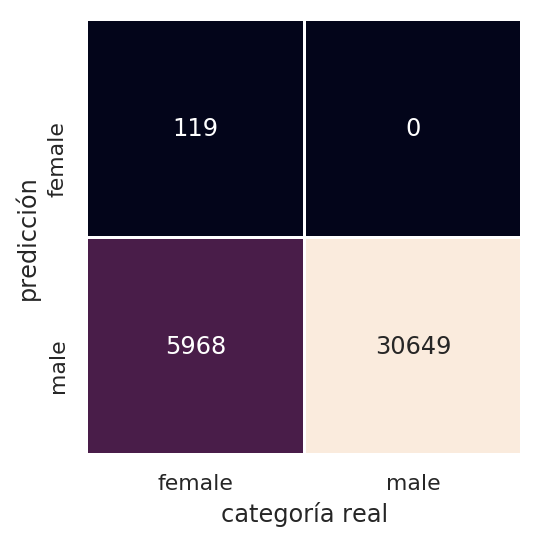

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y2, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, linewidth=1,
            xticklabels=vec.classes_, yticklabels=vec.classes_)
plt.xlabel('categoría real')
plt.ylabel('predicción');

Pues resulta que el clasificador no fue capaz de sortear el sesgo en el dataset. Quizás el hiperparámetro `class_prior` ayuda:

In [19]:
class_priors = records.gender.value_counts(normalize=True, sort=False).loc[vec.classes_]
class_priors

female    0.165698
male      0.834302
Name: gender, dtype: float64

In [20]:
model = MultinomialNB(class_prior=class_priors.values)
model.fit(X1, y1)

MultinomialNB(alpha=1.0, class_prior=array([0.1657, 0.8343]), fit_prior=True)

In [21]:
y_pred = model.predict(X2)
accuracy_score(y2, y_pred)

0.8375435540069687

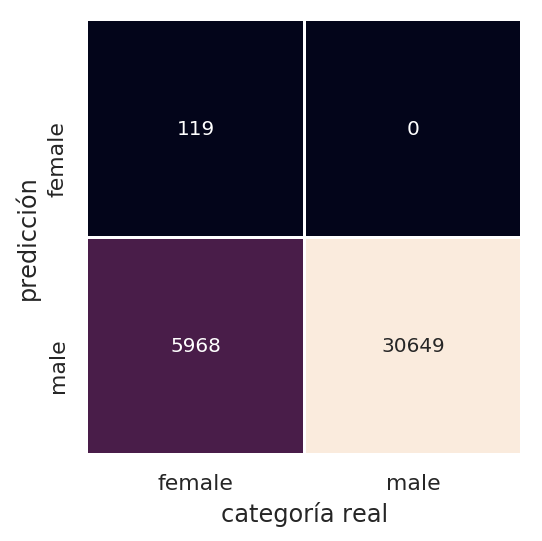

In [22]:
mat = confusion_matrix(y2, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, linewidth=1,
            xticklabels=vec.classes_, yticklabels=vec.classes_)
plt.xlabel('categoría real')
plt.ylabel('predicción');

No.

## Aprendizaje Balanceado (enfoque simple)

Entrenemos el modelo con una cantidad balanceada de clases, utilizando una estrategia ingenua: usemos la misma cantidad de biografías de hombres que de mujeres.

In [23]:
vec.classes_

array(['female', 'male'], dtype=object)

In [24]:
female_idx = np.where(y1 == 0)[0]
female_idx.shape

(6087,)

Ya que hay 6087 mujeres, elegiremos al azar 6087 biografías de hombres.

In [25]:
male_idx = np.where(y1 == 1)[0]
male_idx.shape

(30648,)

In [26]:
balanced_male_idx = np.random.choice(male_idx, size=female_idx.shape[0])
balanced_male_idx.shape

(6087,)

De la matriz de características extraeremos los índices de este nuevo set de entrenamiento:

In [27]:
train_idx = np.hstack([female_idx, balanced_male_idx])
train_idx.shape

(12174,)

In [28]:
balanced_X1 = X1[train_idx,:]
balanced_y1 = y1[train_idx]

Ejecutamos la receta: ajustaremos con el set de entrenamiento, y evaluaremos con el set de validación:

In [30]:
model = MultinomialNB()
model.fit(balanced_X1, balanced_y1)
y_pred = model.predict(X2)
accuracy_score(y2, y_pred)

0.9245154616724739

¡Mejoró! 

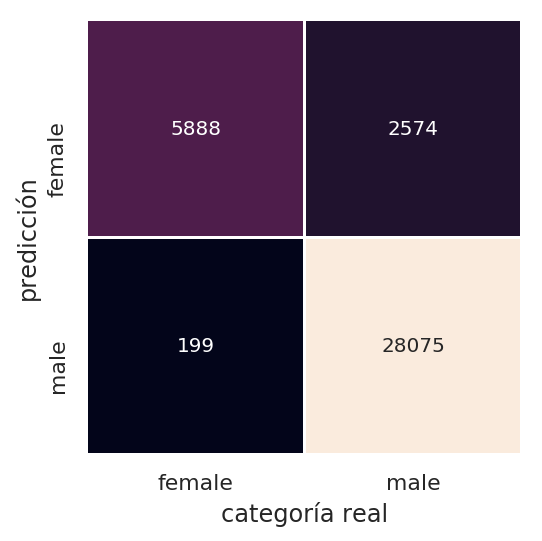

In [31]:
mat = confusion_matrix(y2, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, linewidth=1,
            xticklabels=vec.classes_, yticklabels=vec.classes_)
plt.xlabel('categoría real')
plt.ylabel('predicción');

Sigue habiendo confusión, pero funciona :) 
    
Con esto cerramos este ejemplo. ¿Qué más se les ocurre hacer con estos datos?